In [38]:
import pandas as pd
from azure.cosmos import CosmosClient


# Initialize a connection to the Cosmos database

COSMOS_ENDPOINT = 'https://trisonics-scouting.documents.azure.com:443/'
COSMOS_KEY = '2JY3ncalrujpk6ZM6Qno8bHwP0eMVVCsJ1uSJ53Msp02fp0UvZZNQRBmWf7JCCq3XGgtqfyqtWnQNi3swyifkg=='
db_name = 'ScoutingData'
container_name = 'MatchResults2023'

client = CosmosClient(COSMOS_ENDPOINT, COSMOS_KEY)
db = client.get_database_client(db_name)
container = db.get_container_client(container_name)

In [39]:
# This query grabs all of the data in the database
query = 'SELECT * FROM c where c.event_key = "2023misjo"'

items = container.query_items(query=query, enable_cross_partition_query=True)
# Now we make a Panads dataframe out of our query results
df = pd.DataFrame(items)

# Drop all columns that start with an _, they are internal to Cosmos
df.drop([c for c in df.columns if c.startswith('_')]+['id'], inplace=True, axis=1)

df.drop_duplicates()
display(df.head())

,scouter_name,secret_team_key,event_key,match_key,scouting_team,auto_engaged,auto_docked,auto_community,endgame_engaged,endgame_docked,...,auto_cones_high,auto_cones_medium,auto_cones_low,teleop_cubes_high,teleop_cubes_medium,teleop_cubes_low,teleop_cones_high,teleop_cones_medium,teleop_cones_low,match_notes
0,Nathan Z,4003data,2023misjo,66,5675,True,False,False,False,False,...,0,0,0,2,0,0,0,0,1,Ok at cubes bad at cones
1,Gavin,4003data,2023misjo,66,3604,False,False,False,False,True,...,0,0,0,1,2,0,0,0,0,Auton is overrated
2,Andrew L,4003data,2023misjo,66,3604,False,False,False,False,True,...,0,0,0,1,2,0,0,0,0,Mood lol
3,Shayna Weaver,4003data,2023misjo,66,9228,False,False,False,False,True,...,0,0,0,0,0,0,0,0,0,Casey boy dosent do much
4,Evan,4003data,2023misjo,66,9239,True,False,False,False,False,...,0,0,0,0,1,2,0,0,0,


In [40]:
df.columns

Index(['scouter_name', 'secret_team_key', 'event_key', 'match_key',
       'scouting_team', 'auto_engaged', 'auto_docked', 'auto_community',
       'endgame_engaged', 'endgame_docked', 'endgame_parked',
       'auto_cubes_high', 'auto_cubes_medium', 'auto_cubes_low',
       'auto_cones_high', 'auto_cones_medium', 'auto_cones_low',
       'teleop_cubes_high', 'teleop_cubes_medium', 'teleop_cubes_low',
       'teleop_cones_high', 'teleop_cones_medium', 'teleop_cones_low',
       'match_notes'],
      dtype='object')

In [61]:
def calc_auto_gp_points(x):
    pts = (x.auto_cubes_high+x.auto_cones_high) * 6
    pts += (x.auto_cubes_medium+x.auto_cones_medium) * 4
    pts += (x.auto_cubes_low+x.auto_cones_low) * 3
    return pts 

def calc_auto_cone_gp_points(x):
    pts = x.auto_cones_high * 6
    pts += x.auto_cones_medium * 4
    pts += x.auto_cones_low * 3
    return pts 

def calc_auto_cube_gp_points(x):
    pts = x.auto_cubes_high * 6
    pts += x.auto_cubes_medium * 4
    pts += x.auto_cubes_low * 3
    return pts 


def calc_teleop_gp_points(x):
    pts = (x.teleop_cubes_high+x.teleop_cones_high) * 5 
    pts += (x.teleop_cubes_medium+x.teleop_cones_medium) * 3
    pts += (x.teleop_cubes_low+x.teleop_cones_low) * 2
    return pts 

def calc_teleop_cone_gp_points(x):
    pts = x.teleop_cones_high * 5
    pts += x.teleop_cones_medium * 3
    pts += x.teleop_cones_low * 2
    return pts 

def calc_teleop_cube_gp_points(x):
    pts = x.teleop_cubes_high * 5
    pts += x.teleop_cubes_medium * 3
    pts += x.teleop_cubes_low * 2
    return pts 

def calc_endgame_points(x):
    pts = (1 if x.endgame_engaged else 0) * 10
    pts += (1 if x.endgame_docked else 0) * 6
    pts += (1 if x.endgame_parked else 0) * 2
    return pts 

df['auto_gp_points'] = df.apply(calc_auto_gp_points, axis=1)
df['auto_cone_gp_points'] = df.apply(calc_auto_cone_gp_points, axis=1)
df['auto_cube_gp_points'] = df.apply(calc_auto_cube_gp_points, axis=1)
df['teleop_gp_points'] = df.apply(calc_teleop_gp_points, axis=1)
df['teleop_cone_gp_points'] = df.apply(calc_teleop_cone_gp_points, axis=1)
df['teleop_cube_gp_points'] = df.apply(calc_teleop_cube_gp_points, axis=1)
df['total_gp_points'] = df.auto_gp_points + df.teleop_gp_points
df['total_endgame_points'] = df.apply(calc_endgame_points, axis=1)

In [45]:
gpdf = (
    df.groupby('scouting_team', as_index=False)
      .mean()
      .sort_values('total_gp_points', ascending=False)
)[['scouting_team', 'auto_cone_gp_points', 'auto_cube_gp_points',
   'teleop_cone_gp_points', 'teleop_cube_gp_points', 'total_gp_points']]
gpdf['scouting_team'] = gpdf['scouting_team'].apply(str)
gpdf.head()

gpdf.dtypes

/tmp/ipykernel_2648/3592153370.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('scouting_team', as_index=False)


scouting_team             object
auto_cone_gp_points      float64
auto_cube_gp_points      float64
teleop_cone_gp_points    float64
teleop_cube_gp_points    float64
total_gp_points          float64
dtype: object

In [64]:
edf = (
    df.sort_values('total_endgame_points', ascending=False)
)[['scouting_team', 'total_endgame_points']]
edf['scouting_team'] = edf['scouting_team'].apply(str)
edf.head()
edf.dtypes


scouting_team           object
total_endgame_points     int64
dtype: object

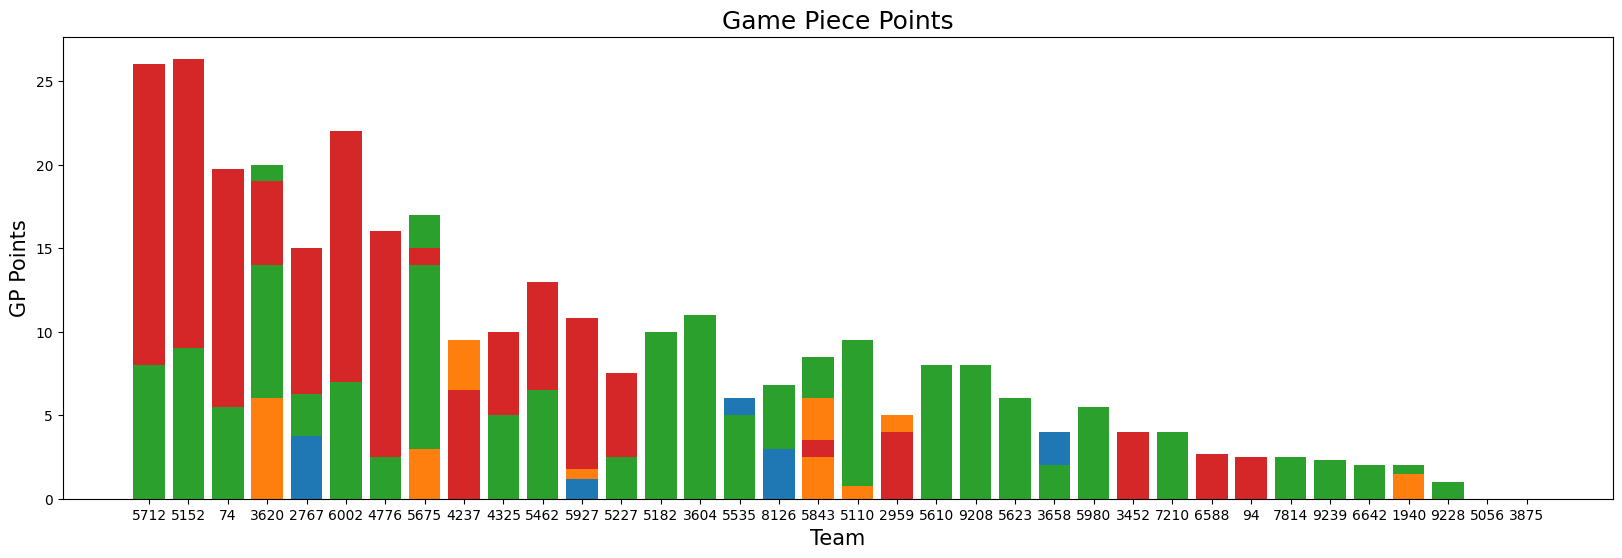

In [46]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
# bar plot with matplotlib
plt.bar('scouting_team', 'auto_cube_gp_points', data=gpdf)
plt.bar('scouting_team', 'auto_cone_gp_points', bottom='auto_cube_gp_points', data=gpdf)
plt.bar('scouting_team', 'teleop_cube_gp_points', bottom='auto_cone_gp_points', data=gpdf)
plt.bar('scouting_team', 'teleop_cone_gp_points', bottom='teleop_cube_gp_points', data=gpdf)
plt.xlabel("Team", size=15)
plt.ylabel("GP Points", size=15)
plt.title("Game Piece Points", size=18)
plt.show()

<Axes: xlabel='scouting_team'>

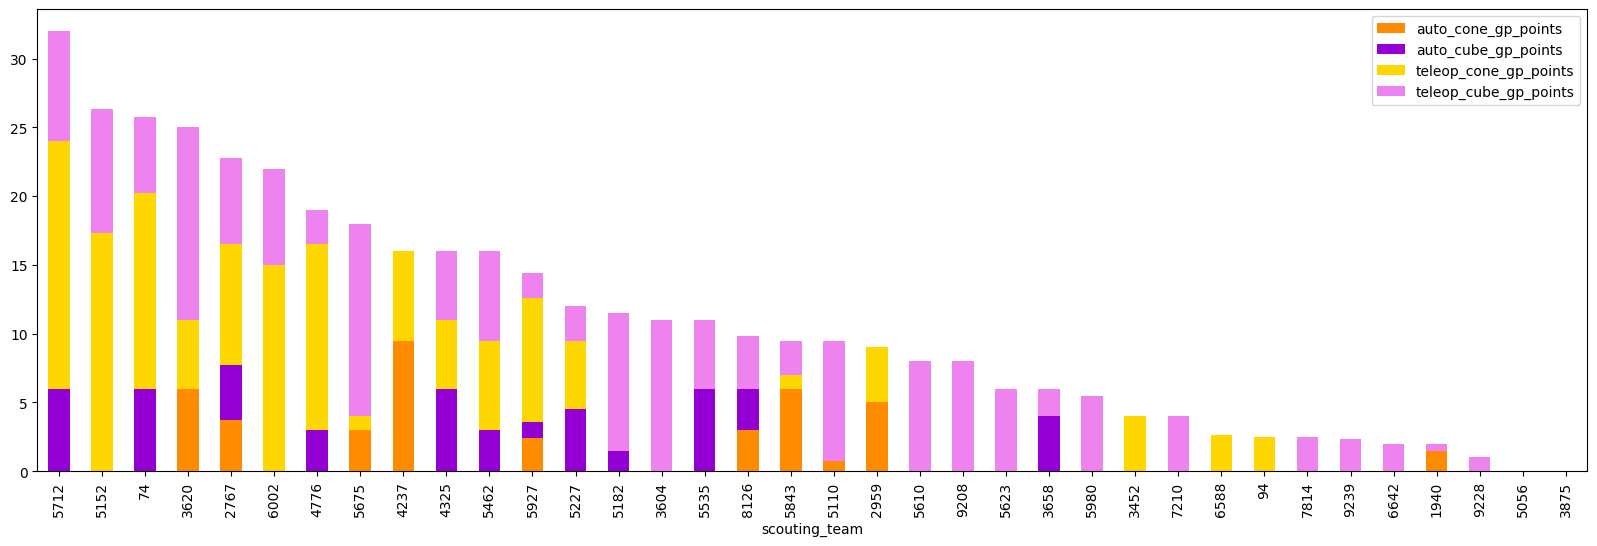

In [59]:
gpdf.set_index('scouting_team', inplace=True)
gpdf.drop(columns='total_gp_points').plot.bar(stacked=True, figsize=(20, 6), color=['darkorange', 'darkviolet', 'gold', 'violet'])

In [ ]:
edf.set_index('scouting_team', inplace=True)
edf.plot.bar(stacked=True, figsize=(20, 6), color='r')
